# Modeling and Simulation in Python

Chapter 19

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Dropping pennies

I'll start by getting the units we'll need from Pint.

In [2]:
m = UNITS.meter
s = UNITS.second

<Unit('second')>

And defining the initial state.

In [3]:
init = State(y=381 * m, 
             v=0 * m/s)

,values
y,381 meter
v,0.0 meter / second


Acceleration due to gravity is about 9.8 m / s$^2$.

In [4]:
g = 9.8 * m/s**2

<Quantity(9.8, 'meter / second ** 2')>

When we call `odeint`, we need an array of timestamps where we want to compute the solution.

I'll start with a duration of 10 seconds.

In [5]:
t_0 = 0 * s
t_end = 10 * s

<Quantity(10, 'second')>

Now we make a `System` object.

In [6]:
system = System(init=init, g=g, t_0=t_0, t_end=t_end)

,values
init,y 381 meter v 0.0 meter / secon...
g,9.8 meter / second ** 2
t_0,0 second
t_end,10 second


And define the slope function.

In [7]:
def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing `g`
    
    returns: derivatives of y and v
    """
    y, v = state
    unpack(system)    

    dydt = v
    dvdt = -g
    
    return dydt, dvdt

It's always a good idea to test the slope function with the initial conditions.

In [8]:
dydt, dvdt = slope_func(init, 0, system)
print(dydt)
print(dvdt)

0.0 meter / second
-9.8 meter / second ** 2


Now we're ready to run `odeint`

In [9]:
results, details = run_ode_solver(system, slope_func)
results

The solver successfully reached the interval end.


,y,v
0.0,381.000,0.00
0.2,380.804,-1.96
0.4,380.216,-3.92
0.6,379.236,-5.88
0.8,377.864,-7.84
1.0,376.100,-9.80
1.2,373.944,-11.76
1.4,371.396,-13.72
1.6,368.456,-15.68
1.8,365.124,-17.64


Here's what it looks like.

Saving figure to file figs/chap09-fig01.pdf


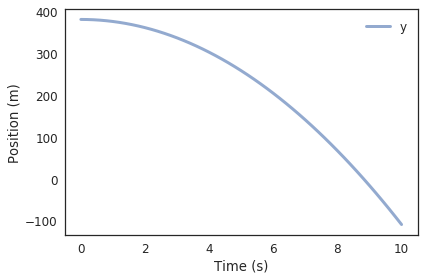

In [10]:
def plot_position(results):
    plot(results.y)
    decorate(xlabel='Time (s)',
             ylabel='Position (m)')

plot_position(results)
savefig('figs/chap09-fig01.pdf')

**Exercise:** By default, `run_ode_solver` returns equally-spaced points in time, but that's not what it really computes.  The ODE solver it uses is adaptive, choosing small time steps when errors are large, and large time steps when errors are small.

Run `run_ode_solver` again with the option `t_eval=None`.  It should return the actual time steps it computed.  What can you infer about how `run_ode_solver` works?

In [11]:
# Solution

# It starts with small time steps.  As long as errors are small,
# it multiplies the time step by about 10.

results, details = run_ode_solver(system, slope_func, t_eval=None)
results

The solver successfully reached the interval end.


,y,v
0.000000,381.000000,0.000000
0.000102,381.000000,-0.001000
0.001122,380.999994,-0.011000
0.011327,380.999371,-0.111000
0.113367,380.937025,-1.110997
1.133773,374.701343,-11.110971
10.000000,-109.000000,-98.000000


In [12]:
# Solution

compute_rel_diff(results.index)

Float64Index([              inf, 9.999999999999998, 9.090909090909092,
               9.00900900900901, 9.000900090009003, 7.820111350719807,
                            nan],
             dtype='float64')

### Onto the sidewalk

To figure out when the penny hit the sidewalk, we can use `crossings`, which finds the times where a `Series` passes through a given value.  In this case, the value is 0.

In [13]:
t_crossings = crossings(results.y, 0)

array([8.81788535])

If `t_crossings` contains no elements, it means we haven't run the simulation long enough.

If it contains more than one element, we might have to figure out what that means.

But for this example, there should be just one, the time when the penny hits the sidewalk.

In [14]:
t_sidewalk = t_crossings[0]

8.817885349707357

We can compare that to the exact result.  Without air resistance, we have

$v = -g t$

and

$y = 381 - g t^2 / 2$

Setting $y=0$ and solving for $t$ yields

$t = \sqrt{\frac{2 y_{init}}{g}}$

In [15]:
sqrt(2 * init.y / g)

<Quantity(8.817885349720552, 'second')>

The estimate is accurate to about 10 decimal places.

## Events

Instead of running the simulation until the penny goes through the sidewalk, it would be better to detect the point where the penny hits the sidewalk and stop.  `run_ode_solver` provides exactly the tool we need, event functions.

Here's an event function that returns the height of the penny above the sidewalk:

In [16]:
def event_func(state, t, system):
    """Return the height of the penny above the sidewalk.
    """
    y, v = state
    return y

And here's how we pass it to `run_ode_solver`.  The solver should run until the event function returns 0, and then terminate.

In [17]:
results, details = run_ode_solver(system, slope_func, events=event_func)
results

A termination event occurred.


,y,v
0.000000,3.810000e+02,0.000000
0.000102,3.810000e+02,-0.001000
0.001122,3.810000e+02,-0.011000
0.011327,3.809994e+02,-0.111000
0.113367,3.809370e+02,-1.110997
1.133773,3.747013e+02,-11.110971
8.817885,5.684342e-14,-86.415276


The message from the solver indicates that "termination event" occurred, and we can check the last time value:

In [18]:
t_sidewalk = get_last_label(results) * s

<Quantity(8.817885349720566, 'second')>

The result is accurate to about 15 decimal places.  Unfortunately, `run_ode_solver` does not carry the units through the computation, so we have to put them back at the end.

We can also check the velocity of the penny when it hits the sidewalk:

In [19]:
v_sidewalk = get_last_value(results.v) * m / s

<Quantity(-86.41527642726155, 'meter / second')>

And convert to kilometers per hour.

In [20]:
km = UNITS.kilometer
h = UNITS.hour
v_sidewalk.to(km / h)

<Quantity(-311.0949951381416, 'kilometer / hour')>

If there were no air resistance, the penny would hit the sidewalk (or someone's head) at more than 300 km/h.

So it's a good thing there is air resistance.

## Under the hood

Here is the source code for `crossings` so you can see what's happening under the hood:

In [21]:
%psource crossings

def crossings(series, value):
    """Find the labels where the series passes through value.

    The labels in series must be increasing numerical values.

    series: Series
    value: number

    returns: sequence of labels
    """
    interp = InterpolatedUnivariateSpline(series.index, series-value)
    return interp.roots()


### Exercises

**Exercise:** Here's a question from the web site [Ask an Astronomer](http://curious.astro.cornell.edu/about-us/39-our-solar-system/the-earth/other-catastrophes/57-how-long-would-it-take-the-earth-to-fall-into-the-sun-intermediate):

"If the Earth suddenly stopped orbiting the Sun, I know eventually it would be pulled in by the Sun's gravity and hit it. How long would it take the Earth to hit the Sun? I imagine it would go slowly at first and then pick up speed."

Use `run_ode_solver` to answer this question.  Hints:

1.  Look up the Law of Universal Gravitation and any constants you need.  I suggest you work entirely in SI units.

2.  When the distance between the Earth and the Sun gets small, this system behaves badly, so you should use an event function to stop when the surface of Earth reaches the surface of the Sun.

3. Express your answer in days, and plot the results as millions of kilometers versus days.

If you read the reply by Dave Rothstein, you will see other ways to solve the problem, and a good discussion of the modeling decisions behind them.

In [22]:
# Solution

N = UNITS.newton
kg = UNITS.kilogram
m = UNITS.meter
AU = UNITS.astronomical_unit

<Unit('astronomical_unit')>

In [23]:
# Solution

r_0 = (1 * AU).to_base_units()
v_0 = 0 * m / s
init = State(r=r_0,
             v=v_0)

,values
r,149597870691.0 meter
v,0.0 meter / second


In [24]:
# Solution

r_earth = 6.371e6 * m
r_sun = 695.508e6 * m

system = System(init=init,
                G=6.674e-11 * N / kg**2 * m**2,
                m1=1.989e30 * kg,
                r_final=r_sun + r_earth,
                m2=5.972e24 * kg,
                t_0=0 * s,
                t_end=1e7 * s)

,values
init,r 149597870691.0 meter v 0.0 meter / s...
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
m1,1.989e+30 kilogram
r_final,701879000.0 meter
m2,5.972e+24 kilogram
t_0,0 second
t_end,10000000.0 second


In [25]:
# Solution

def universal_gravitation(state, system):
    r, v = state
    unpack(system)
    
    force = G * m1 * m2 / r**2
    return force

In [26]:
# Solution

universal_gravitation(init, system)

<Quantity(3.5423376937972604e+22, 'newton')>

In [27]:
# Solution

def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing `g`
    
    returns: derivatives of y and v
    """
    y, v = state
    unpack(system)    

    force = universal_gravitation(state, system)
    dydt = v
    dvdt = -force / m2
    
    return dydt, dvdt

In [28]:
# Solution

slope_func(init, 0, system)

(<Quantity(0.0, 'meter / second')>,
 <Quantity(-0.005931576848287442, 'newton / kilogram')>)

In [29]:
# Solution

def event_func(state, t, system):
    r, v = state
    return r - system.r_final

In [30]:
# Solution

event_func(init, 0, system)

<Quantity(148895991691.0, 'meter')>

In [31]:
# Solution

results, details = run_ode_solver(system, slope_func, events=event_func)
details

A termination event occurred.


,values
message,A termination event occurred.
nfev,230
njev,0
nlu,0
sol,None
status,1
success,True
t_events,[[5577323.2573304195]]


In [32]:
# Solution

t_event = details.t_events[0] * s

<Quantity([5577323.25733042], 'second')>

In [33]:
# Solution

t_event.to(UNITS.day)

<Quantity([64.55235252], 'day')>

In [34]:
# Solution

ts = linspace(t_0, t_event, 201)
results, details = run_ode_solver(system, slope_func, events=event_func, t_eval=ts)

A termination event occurred.


In [35]:
# Solution

results.index /= 60 * 60 * 24

In [36]:
# Solution

results.r /= 1e9

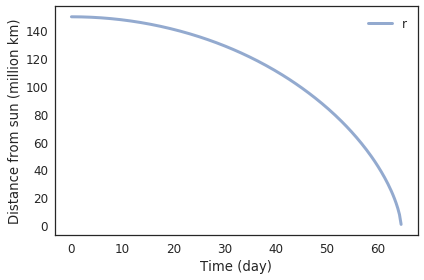

In [37]:
# Solution

plot(results.r)

decorate(xlabel='Time (day)',
         ylabel='Distance from sun (million km)')

### With air resistance

Next we'll add air resistance using the [drag equation](https://en.wikipedia.org/wiki/Drag_equation)

First I'll create a `Params` object to contain the quantities we'll need.

In [38]:
params = Params(height = 381 * m,
                v_init = 0 * m / s,
                g = 9.8 * m/s**2,
                mass = 2.5e-3 * kg,
                diameter = 19e-3 * m,
                rho = 1.2 * kg/m**3,
                v_term = 18 * m / s,
                t_0 = 0 * s,
                t_end = 30 * s)

,values
height,381 meter
v_init,0.0 meter / second
g,9.8 meter / second ** 2
mass,0.0025 kilogram
diameter,0.019 meter
rho,1.2 kilogram / meter ** 3
v_term,18.0 meter / second
t_0,0 second
t_end,30 second


Now here's a version of `make_system` that takes a `Params` object as a parameter.

`make_system` uses the given value of `v_term` to compute the drag coefficient `C_d`.

In [39]:
def make_system(params):
    """Makes a System object for the given conditions.
    
    params: Params with height, g, mass, diameter, 
               rho, v_term, and duration
    
    returns: System with init, g, mass, rho, C_d, area, and ts
    """
    unpack(params)
    
    init = State(y=height, v=v_init)
    area = np.pi * (diameter/2)**2
    C_d = 2 * mass * g / (rho * area * v_term**2)
    
    return System(params, init=init, area=area, C_d=C_d)

Let's make a `System`

In [40]:
system = make_system(params)
system

,values
height,381 meter
v_init,0.0 meter / second
g,9.8 meter / second ** 2
mass,0.0025 kilogram
diameter,0.019 meter
rho,1.2 kilogram / meter ** 3
v_term,18.0 meter / second
t_0,0 second
t_end,30 second
init,y 381 meter v 0.0 meter / secon...


Here's the slope function, including acceleration due to gravity and drag.

In [41]:
def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing g, rho,
            C_d, area, and mass
    
    returns: derivatives of y and v
    """
    y, v = state
    unpack(system)
    
    f_drag = rho * v**2 * C_d * area / 2
    a_drag = f_drag / mass
    
    dydt = v
    dvdt = -g + a_drag
    
    return dydt, dvdt

As always, let's test the slope function with the initial conditions.

In [42]:
slope_func(system.init, 0, system)

(<Quantity(0.0, 'meter / second')>, <Quantity(-9.8, 'meter / second ** 2')>)

We can use the same event function as last time.

In [43]:
def event_func(state, t, system):
    """Return the height of the penny above the sidewalk.
    """
    y, v = state
    return y

And then run the simulation.

In [44]:
results, details = run_ode_solver(system, slope_func, events=event_func)

A termination event occurred.


First check that the simulation ran long enough for the penny to land.

In [45]:
results

,y,v
0.000000,3.810000e+02,0.000000
0.000102,3.810000e+02,-0.001000
0.001122,3.810000e+02,-0.011000
0.011327,3.809994e+02,-0.110998
0.113367,3.809371e+02,-1.109588
1.133773,3.750650e+02,-9.886284
2.336542,3.593541e+02,-15.381283
3.679032,3.370777e+02,-17.358218
5.021521,3.133656e+02,-17.847263
6.657291,2.840359e+02,-17.971703


Then compute the flight time.

In [46]:
t_sidewalk = get_last_label(results)

22.439075231128985

Setting the duration to the computed flight time, we can check the final conditions.

In [47]:
v_sidewalk = get_last_value(results.v)

-18.011550459195657

Interestingly, the final velocity is not exactly terminal velocity, which suggests that there are some numerical errors.

Here's the plot of position as a function of time.

Saving figure to file figs/chap09-fig02.pdf


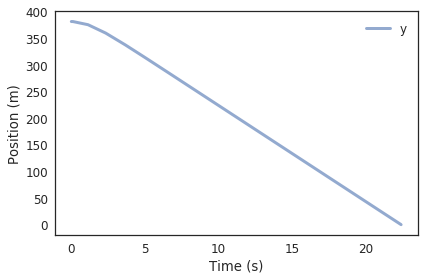

In [48]:
plot_position(results)
savefig('figs/chap09-fig02.pdf')

And velocity as a function of time:

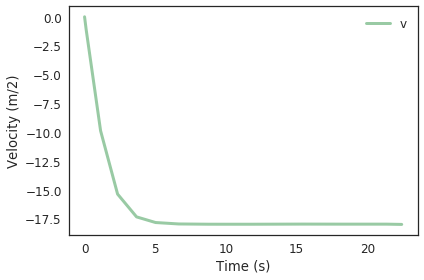

In [49]:
def plot_velocity(results):
    plot(results.v, color='C1', label='v')
        
    decorate(xlabel='Time (s)',
             ylabel='Velocity (m/2)')
    
plot_velocity(results)

From an initial velocity of 0, the penny accelerates downward until it reaches terminal velocity; after that, velocity is constant.

**Exercise:** Run the simulation with an initial velocity, downward, that exceeds the penny's terminal velocity.  Hint: the `Params` object provides a function called `set`.

What do you expect to happen?  Plot velocity and position as a function of time, and see if they are consistent with your prediction.

In [50]:
# Solution

params.set(v_init = -30 * m / s)
system = make_system(params)
results, details = run_ode_solver(system, slope_func, events=event_func)

A termination event occurred.


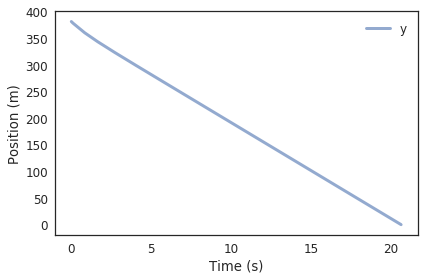

In [51]:
plot_position(results)

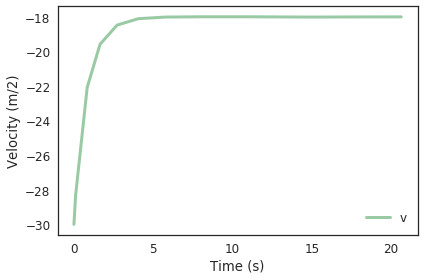

In [52]:
# Solution

plot_velocity(results)

### Dropping quarters

Suppose we drop a quarter from the Empire State Building and find that its flight time is 19.1 seconds.  We can use this measurement to estimate the coefficient of drag.

Here's a `Params` object with the relevant parameters from
https://en.wikipedia.org/wiki/Quarter_(United_States_coin)


In [53]:
params = Params(height = 381 * m,
                v_init = 0 * m / s,
                g = 9.8 * m/s**2,
                mass = 5.67e-3 * kg,
                diameter = 24.26e-3 * m,
                rho = 1.2 * kg/m**3,
                t_0 = 0 * s,
                t_end = 19.1 * s)

,values
height,381 meter
v_init,0.0 meter / second
g,9.8 meter / second ** 2
mass,0.00567 kilogram
diameter,0.02426 meter
rho,1.2 kilogram / meter ** 3
t_0,0 second
t_end,19.1 second


And here's a modified version of `make_system`

In [54]:
def make_system(params):
    """Makes a System object for the given conditions.
    
    params: Params with height, v_init, g, mass, diameter, 
               rho, C_d, and duration
    
    returns: System with init, g, mass, rho, C_d, area, and ts
    """
    unpack(params)
    
    init = State(y=height, v=v_init)
    area = np.pi * (diameter/2)**2
    
    return System(params, init=init, area=area)

We can run the simulation with an initial guess of `C_d=0.4`.

In [55]:
params.set(C_d=0.4)
system = make_system(params)
results, details = run_ode_solver(system, slope_func)

The solver successfully reached the interval end.


The final height is -11 meters, which means our guess was too low (we need more drag to slow the quarter down).

In [56]:
get_last_value(results.y)

-11.072723625387098

`height_func` takes a hypothetical value of `C_d` and returns the height after 19.1 seconds.

In [57]:
def height_func(C_d, params):
    """Final height as a function of C_d.
    
    C_d: drag coefficient
    params: Params object
    
    returns: height in m
    """
    params.set(C_d=C_d)
    system = make_system(params)
    results, details = run_ode_solver(system, slope_func)
    return get_last_value(results.y)

If we run it with `C_d=0.4`, we get -11 meters again.

In [58]:
height_func(0.4, params)

The solver successfully reached the interval end.


-11.072723625387098

Now we can use `fsolve` to find the value of `C_d` that makes the final height 0.

In [59]:
solution = fsolve(height_func, 0.4, params)

The solver successfully reached the interval end.
The solver successfully reached the interval end.
The solver successfully reached the interval end.
The solver successfully reached the interval end.
The solver successfully reached the interval end.
The solver successfully reached the interval end.
The solver successfully reached the interval end.
The solver successfully reached the interval end.
The solver successfully reached the interval end.
The solver successfully reached the interval end.


array([0.42595161])

Plugging in the estimated value, we can run the simulation again to get terminal velocity.

In [60]:
params.set(C_d=solution)
system = make_system(params)
results, details = run_ode_solver(system, slope_func)
get_last_value(results.v) * m / s

The solver successfully reached the interval end.


<Quantity(-21.68355627049694, 'meter / second')>

In this example, the terminal velocity of the quarter is higher than that of the penny.  We should not take this result too seriously because the measurements we used are not real; I made them up.